# Introduction
#### she changlue
20th April 2017

This project use LSTM model to handle text classification problems.


this notebook will process as follow:
1. load library and raw corpus data
2. cut the corpus in to a list format
3. encode the tokens and corpus
4. construct model and train
5. use kmeans to do tokens' and docs' cluster 
6. use T-SNE to visualization
7. save the outcomes

### 1)   load library and raw corpus data

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib

from sklearn.cluster import KMeans#cluster

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import jieba.posseg as pseg # cut the documents with token and tags
import jieba
import tensorflow as tf

from sklearn.manifold import TSNE#cluster

from subprocess import check_output
print(check_output(["ls", "corpus"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

custormTokens.txt
opr_rem.csv
催收sample.csv
马上消费金融_jiuhui.wu_2017-04-05.csv



In [4]:
jieba.load_userdict('corpus/custormTokens.txt')  
rawdata = pd.read_csv('corpus/马上消费金融_jiuhui.wu_2017-04-05.csv', header=0,encoding='gbk')

#### corpus briefing

In [5]:
rawdata.head()

,记录时间,会话Id,消息来源,消息目标,消息内容
0,2017-04-05 10:04:42,e3b8a805f67d4fa493b95b6a7ef0c90d,王文,机器人,怎么能提前还款
1,2017-04-05 10:04:42,e3b8a805f67d4fa493b95b6a7ef0c90d,机器人,王文,<p>15天内提前还款：请您直接拨打4000368876客服热线咨询立即结清金额，并在保证绑...
2,2017-04-05 10:05:26,e3b8a805f67d4fa493b95b6a7ef0c90d,王文,机器人,提前还款利息
3,2017-04-05 10:05:26,e3b8a805f67d4fa493b95b6a7ef0c90d,机器人,王文,<p>只要没有任何逾期款项即可申请提前还款，结清分期贷款，终止合同，提前还款服务费200元。...
4,2017-04-05 10:05:30,c72277e3a93949858e838cd5d3f62c92,11674001,机器人,你们客户打不通啊


In [6]:
rawdata.shape

(56457, 5)

In [7]:
rawdata.describe()

,记录时间,会话Id,消息来源,消息目标,消息内容
count,56457,56457,56457,56457,56448
unique,25923,10002,7970,7970,17627
top,2017-04-05 12:47:55,5ca2cb3990b249e987b5e98dc40a7f4e,机器人,机器人,1
freq,11,357,28229,28228,5643


### 2) cut the corpus in to a list format

In [8]:
tokenCorpus  = []#corpus list of cutted tokens
rawSentences = []#raw text 
documents    = list(rawdata[rawdata['消息目标']=='机器人']['消息内容'])#text which is send by custormers
#documents    = list(rawdata['opr_rem'])#text which is send by custormers

In [9]:
# cstruct the corpus
for sentence in documents:
    if len(str(sentence))>4:
        sentence = sentence.replace('\t','')
        words = [pair.word for pair in pseg.lcut(sentence) if pair.flag in ['n','ns','vs','nv','v']]       
        if len(words)>1:
            tokenCorpus.append(words)
            rawSentences.append(sentence)

In [10]:
tokenCorpus[:3]

[['能', '提前', '还款'], ['提前', '还款', '利息'], ['客户', '打']]

In [11]:
rawSentences[:5]

['怎么能提前还款', '提前还款利息', '你们客户打不通啊', '我申请贷款，资料也已经提交了。为什么会显示取消？', '逾期一天会不会影响？']

### 3) encode the tokens and corpus

In [12]:
HP_miniTokenFreq = 3 #minimal tokens frequency
tokenCount = dict()  #token count
token2code = dict()  #token to code
code2token = ['inFreqTokens'] #code to token
code       = 1       #code

##### transfer token into codes

In [13]:
#get token frequency
for tokens in tokenCorpus:
    for token in tokens:
        tokenCount.setdefault(token,0)
        tokenCount[token]+=1  
#encode those tokens which have minumal frequency
for token in tokenCount:
    if tokenCount[token] > HP_miniTokenFreq:       
        token2code[token] = code
        code += 1
        code2token.append(token)
    else:
        token2code[token] = 0
#transfer the raw token corpus into encoded corpus
codeCorpus = []
for tokens in tokenCorpus:          
    codeCorpus.append([token2code[token]for token in tokens])

### 4) construct model and train

In [14]:
HP_topicNums = 8
documNums = len(codeCorpus)
tokenNums = len(code2token)
print("the training documents num:",documNums)
print("the training tokens    num:",tokenNums)

the training documents num: 9379
the training tokens    num: 503


##### dense list to sparse numpy

In [15]:
tokenDocMat = np.zeros(shape=(documNums,tokenNums),dtype=np.float32)
for docIdx in range(documNums):
    tokenDocMat[docIdx][codeCorpus[docIdx]]=1
docTokenNum = tokenDocMat.sum(axis=1).reshape((-1,1))   

In [16]:
docIndxSpan = np.array(range(documNums),dtype=np.int32)

##### construct the graph

In [17]:
#embedding initial
docum2topicEmbed  = tf.Variable(tf.random_uniform([documNums,HP_topicNums], -1.0, 1.0))
token2topicWeight = tf.Variable(tf.random_uniform([HP_topicNums,tokenNums], -1.0, 1.0))

In [18]:
#placeholder
document_idx   = tf.placeholder(tf.int32, shape=[None])
document_embed = tf.nn.embedding_lookup(docum2topicEmbed , document_idx) 
multiplier     = tf.placeholder(tf.float32, shape=[None,1])
tokensInDoc    = tf.placeholder(tf.float32,shape=[None,tokenNums])

In [19]:
#forward 
with tf.name_scope("TM"):
    documentembed_Sfmx     = tf.nn.softmax(document_embed)
    token2topicWeight_Sfmx = tf.nn.softmax(token2topicWeight,dim=0)
    tokensInDoc_pred       = tf.nn.softmax(tf.matmul(documentembed_Sfmx,token2topicWeight_Sfmx))*multiplier                           

In [20]:
# use least squre loss to train model
with tf.name_scope("loss"):   
    loss = tf.reduce_mean(tf.square(tokensInDoc - tokensInDoc_pred))

In [21]:
learning_rate = 0.001
with tf.name_scope("train"):
    optimizer   = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [22]:
#initial and save
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### training the tensorflow graph

In [ ]:
#start training
n_epochs   = 100
batch_size = 1000
batch_num  = documNums//batch_size+1
 
with tf.Session() as sess:    
    init.run()
    for epoch in range(n_epochs):
        for batch in range(batch_num):
            #loop 
            for i in range(100):
            #feed rawdata
                document_idx_batch = docIndxSpan [batch*batch_size:(batch+1)*batch_size]
                multiplier_batch   = docTokenNum [batch*batch_size:(batch+1)*batch_size]
                tokensInDoc_batch  = tokenDocMat [batch*batch_size:(batch+1)*batch_size]

                #training
                sess.run(training_op, feed_dict={document_idx : document_idx_batch,
                                                 multiplier   : multiplier_batch,
                                                 tokensInDoc  : tokensInDoc_batch})  
        if epoch%10==0:
            train_loss = loss.eval(feed_dict={document_idx : docIndxSpan[:20000],
                                              multiplier   : docTokenNum[:20000],
                                              tokensInDoc  : tokenDocMat[:20000]})
            print(train_loss)
    save_path = saver.save(sess,"tfsave/topic_model.ckpt")
    # get embedding
    documMat = documentembed_Sfmx.eval(feed_dict={document_idx : docIndxSpan})
    tokenMat = token2topicWeight_Sfmx.eval()

0.00613169


In [24]:
documMat.sum(axis=1)[:5],tokenMat.sum(axis=0)[:5]

(array([ 0.99999988,  1.        ,  1.        ,  0.99999988,  1.00000012], dtype=float32),
 array([ 1.,  1.,  1.,  1.,  1.], dtype=float32))

#### show the rough topic

In [25]:
topK = 3
outDF = []
keyWords = []
keySentences = []
for idx in range(HP_topicNums):    
    ords = np.argsort(-tokenMat[idx])[:topK]
    tmp = ['主题'+str(idx+1)]
    tmp += [code2token[i]for i in ords]
    keyWords+=tmp
    ords = np.argsort(-documMat.T[idx])[:topK]
    tmp = ['------------------------------']
    tmp +=[rawSentences[i]for i in ords]
    keySentences+=tmp
outDF = [keyWords,keySentences] 

In [26]:
pd.DataFrame(outDF).T.head(30)

,0,1
0,主题1,------------------------------
1,额,多久能放款
2,有没有,我没京东账号
3,信用卡,我的贷款扣款失败
4,主题2,------------------------------
5,详询,我的还款四是多少
6,能,提前还款利息有没有少
7,要,钱已经从我银行卡扣除了为什么还是显示待还款
8,主题3,------------------------------
9,申请单,发个邀请码来


### 5)  use kmeans to do tokens' and docs' cluster

In [27]:
tokenMat_KM = KMeans(n_clusters=HP_topicNums, random_state=0).fit(tokenMat.T)
documMat_KM = KMeans(n_clusters=HP_topicNums, random_state=0).fit(documMat)

In [28]:
tokenMat_Label = tokenMat_KM.labels_
documMat_Label = documMat_KM.labels_

### 6)  use T-SNE to visualization

In [29]:
tokenMat_tsne_embed = TSNE(random_state=1).fit_transform(tokenMat.T)  
documMat_tsne_embed = TSNE(random_state=1).fit_transform(documMat)  

KeyboardInterrupt: 

##### the visualization of word embeddings

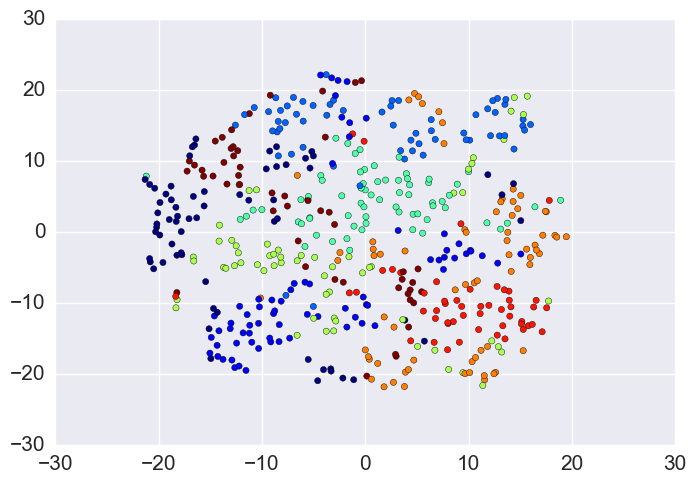

In [30]:
plt.scatter(tokenMat_tsne_embed[:,0],tokenMat_tsne_embed[:,1],c=tokenMat_Label, cmap=plt.cm.get_cmap("jet", 10))

##### the visualization of document embeddings

In [31]:
plt.scatter(documMat_tsne_embed[:,0],documMat_tsne_embed[:,1],c=documMat_Label, cmap=plt.cm.get_cmap("jet", 10))

NameError: name 'documMat_tsne_embed' is not defined

### 7)  save the outcomes

In [ ]:
outDF= pd.DataFrame()
outDF['text']=rawSentences
outDF['label']=documMat_Label

In [ ]:
outDF.head()

In [ ]:
outDF.to_csv('save/docLabel.csv',encoding='gbk',index=False)